#ここを見る

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#インストール
!pip install -q japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
#import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from scipy import stats
import copy

In [ ]:
#csv読み込み
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI・データサイエンス実践プログラム/中間テスト/exercise.csv')

###データのグループ化
- 割引（Discount）
-Buy One Get One（一つ購入で一つプレゼント）
-オファー無し（No Offer）

In [ ]:
Discount_df = df[df['offer']=='Discount']
Discount_df = Discount_df.drop(['offer'], axis=1)
Discount_df.reset_index()
BuyOne_df = df[df['offer']=='Buy One Get One']
BuyOne_df = BuyOne_df.drop(['offer'], axis=1)
NoOffer_df = df[df['offer']=='No Offer']
NoOffer_df = NoOffer_df.drop(['offer'], axis=1)
DF = df

In [ ]:
print(Discount_df.shape)
print(BuyOne_df.shape)
print(NoOffer_df.shape)

(21307, 8)
(21387, 8)
(21306, 8)


##Discount

In [ ]:
df = Discount_df

In [ ]:
# df = BuyOne_df

In [ ]:
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,conversion
3,9,675.83,1,0,Rural,1,Web,0
8,9,675.07,1,1,Rural,1,Phone,0
13,2,101.64,0,1,Urban,0,Web,1
16,5,29.99,1,0,Surburban,0,Phone,0
17,9,112.35,1,0,Rural,0,Web,0
...,...,...,...,...,...,...,...,...
63994,7,86.46,0,1,Urban,0,Web,0
63995,10,105.54,1,0,Urban,0,Web,0
63996,5,38.91,0,1,Urban,1,Phone,0
63997,6,29.99,1,0,Urban,1,Phone,0


####OneHotEncoding

In [ ]:
hot_df = pd.get_dummies(df, dtype=int)
hot_df.head()

,recency,history,used_discount,used_bogo,is_referral,conversion,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
3,9,675.83,1,0,1,0,1,0,0,0,0,1
8,9,675.07,1,1,1,0,1,0,0,0,1,0
13,2,101.64,0,1,0,1,0,0,1,0,0,1
16,5,29.99,1,0,0,0,0,1,0,0,1,0
17,9,112.35,1,0,0,0,1,0,0,0,0,1


In [ ]:
hot_df.shape

(21307, 12)

####クラスタリング

In [ ]:
# 正規性の確認
stats.kstest(Discount_df['recency'], "norm")
# 0.05より小さい　-> 正規分布ではない

KstestResult(statistic=0.8413447460685429, pvalue=0.0, statistic_location=1, statistic_sign=-1)

In [ ]:
# マンホイットニーのu検定
stats.mannwhitneyu(Discount_df['recency'], Discount_df['conversion'], alternative = 'two-sided')
# p < 0.05 つまり平均値に差がある

MannwhitneyuResult(statistic=448219288.0, pvalue=0.0)

In [ ]:
# 正規性の確認
stats.kstest(Discount_df['history'], "norm")
# 0.05より小さい　-> 正規分布ではない

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=29.99, statistic_sign=-1)

In [ ]:
# マンホイットニーのu検定
stats.mannwhitneyu(Discount_df['history'], Discount_df['conversion'], alternative = 'two-sided')
# p < 0.05 つまり平均値に差がある

MannwhitneyuResult(statistic=453988249.0, pvalue=0.0)

- 検定結果
  - recency
    - コルモゴロフ・スミルノフ:正規性なし
    - マンホイットニーのu検定:conversionの平均値との間に差がある
  - history
    - コルモゴロフ・スミルノフ:正規性なし
    - マンホイットニーのu検定:conversionの平均値との間に差がある

- 結論
  - recencyとhistoryについてconversionとの

In [ ]:
number = ['recency', 'history']
category = ['used_discount', 'used_bogo', 'is_referral',
       'conversion', 'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
       'channel_Multichannel', 'channel_Phone', 'channel_Web']

In [ ]:
#数値型を抽出
df = hot_df[['history', 'recency']]
# NumPy 型へキャスト
x = df.values
type(x)

numpy.ndarray

In [ ]:
from sklearn.cluster import KMeans
#インスタンス化
#エルボー法でクラスタの数は３になりました
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(x)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=0)

In [ ]:
# クラスタリングの実行
cluster = kmeans.labels_
print(cluster)

[0 0 1 ... 1 1 0]


In [ ]:
# clusterカラムの追加
hot_df['cluster'] = cluster
hot_df.head()

,recency,history,used_discount,used_bogo,is_referral,conversion,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,cluster
3,9,675.83,1,0,1,0,1,0,0,0,0,1,0
8,9,675.07,1,1,1,0,1,0,0,0,1,0,0
13,2,101.64,0,1,0,1,0,0,1,0,0,1,1
16,5,29.99,1,0,0,0,0,1,0,0,1,0,1
17,9,112.35,1,0,0,0,1,0,0,0,0,1,1


In [ ]:
groups = hot_df.groupby('cluster')
groups.size()

cluster
0     5448
1    14614
2     1245
dtype: int64

In [ ]:
groups.agg(['mean'])

,recency,history,used_discount,used_bogo,is_referral,conversion,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
cluster,,,,,,,,,,,,
0,5.035793,425.920508,0.618025,0.612151,0.466226,0.223752,0.147761,0.439978,0.412261,0.299009,0.346733,0.354258
1,6.253592,109.277109,0.513070,0.517517,0.472218,0.163063,0.153894,0.447448,0.398659,0.030724,0.477487,0.491789
2,3.368675,1009.409301,0.702008,0.683534,1.000000,0.234538,0.151807,0.453815,0.394378,0.400803,0.299598,0.299598


数値の条件：cluster==0 or cluster==2

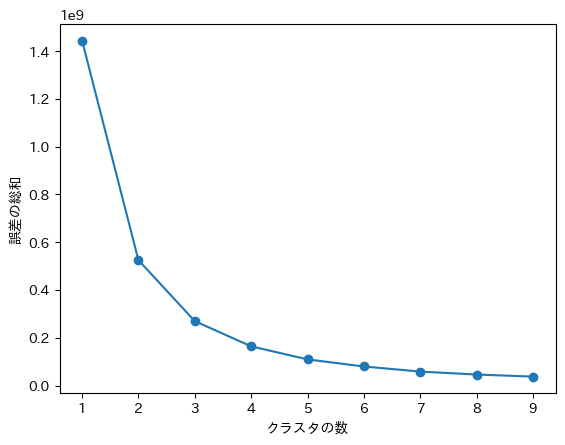

In [ ]:
distortions = []
#エルボー法実施後の残骸
for i  in range(1,10):
    km = KMeans(n_clusters=i,
                n_init=10,
                random_state=0)
    km.fit(x)
    distortions.append(km.inertia_)

plt.plot(range(1,10),distortions,marker='o')
plt.xlabel('クラスタの数')
plt.ylabel('誤差の総和')
plt.show()

In [ ]:
# clusterカラムの追加
hot_df['cluster'] = cluster

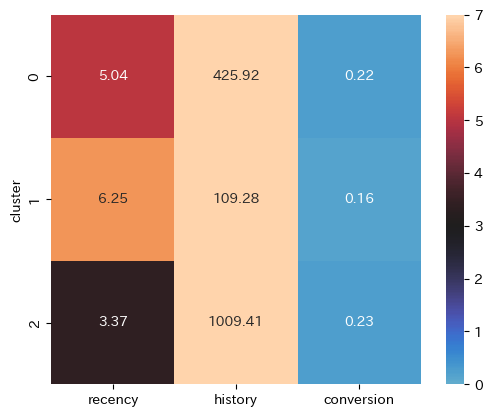

In [ ]:
mean = groups[['recency', 'history', 'conversion']].mean()
sns.heatmap(mean, square=True, annot=True, fmt='.2f', vmax=7.0, center=3.0, vmin=0.0);
plt.savefig('/content/drive/MyDrive/Colab Notebooks/AI・データサイエンス実践プログラム/中間テスト/discount_cluster')

In [ ]:
Discount_df['conversion'].mean()

0.18275684047496127

In [ ]:
groups['conversion'].mean()

cluster
0    0.223752
1    0.163063
2    0.234538
Name: conversion, dtype: float64

クラスタリングの結果
- クラスタ0
  - recencyが大きすぎない
  - historyが大きい
- クラスタ1
  - recencyが大きめ
  - historyが小さい
- クラスタ2
  - recencyが小さめ
  - historyが大きめ

- conversionの平均値
  - 全体
    - 0.18275684047496127
  - クラスタ0
    - 0.223752
  - クラスタ1
    - 0.163063
  - クラスタ2
    - 0.234538

- 結論
  conversionの平均値が向上したクラスタ0と2の傾向のユーザに割引のプロモーションを送る
  - recencyは大きくない
  - historyは大きい
  ユーザに対して割引のプロモーションを送る

####χ二乗検定

帰無仮説：二つの変数は独立である

In [ ]:
#p < 0.05の列を出力
from scipy import stats
for col in category:
    crosstab = pd.crosstab(hot_df['conversion'], hot_df[col])
    chi2, p, dof, ef = stats.chi2_contingency(crosstab, correction=False)
    if p < 0.05:
        print(col)
        # print(f'χ 二乗値:{chi2}')
        print(p)
        # print(ef)

used_discount
2.382457266121364e-08
used_bogo
2.636441967345585e-06
is_referral
2.0695601576136225e-27
conversion
0.0
zip_code_Rural
1.5215308993865983e-12
zip_code_Surburban
0.0014362678539822473
channel_Multichannel
5.6981076887715076e-05
channel_Phone
3.9572114220769366e-11
channel_Web
7.944482077046295e-05


↑上記の項目は帰無仮説を棄却＝独立ではない

In [ ]:
group=hot_df.groupby('conversion')

In [ ]:
group.mean().shape

(2, 12)

In [ ]:
group.mean()

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,cluster
conversion,,,,,,,,,,,,
0,5.906736,234.395038,0.541951,0.543847,0.519095,0.143973,0.451042,0.404985,0.116694,0.444266,0.439040,0.811865
1,5.178480,280.581505,0.591166,0.585259,0.422958,0.189009,0.422958,0.388033,0.139959,0.386235,0.473806,0.761941


In [ ]:
group['zip_code_Surburban'].mean() - group['zip_code_Rural'].mean()

conversion
0    0.307069
1    0.233950
dtype: float64

カテゴリの条件：is_referral==0 and zip_code_Rural==1

In [ ]:
group.mean().to_csv('/content/drive/MyDrive/Colab Notebooks/AI・データサイエンス実践プログラム/中間テスト/chi2.csv')

↑p値によってとりあえず決めたので仮

In [ ]:
#カテゴリの条件
discussion = hot_df.query('is_referral==0 and zip_code_Rural==1')
#数値の条件
discussion = discussion.query('cluster==0 or cluster==2')
discussion.shape

(440, 13)

In [ ]:
#Discount全体のconversion確率
hot_df['conversion'].mean()

0.18275684047496127

In [ ]:
#条件適用後のconversion確率
discussion['conversion'].mean()

0.29545454545454547

# 回帰

In [ ]:
import statsmodels.api as sm

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [ ]:
hot_df

,recency,history,used_discount,used_bogo,is_referral,conversion,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,cluster
3,9,675.83,1,0,1,0,1,0,0,0,0,1,0
8,9,675.07,1,1,1,0,1,0,0,0,1,0,0
13,2,101.64,0,1,0,1,0,0,1,0,0,1,1
16,5,29.99,1,0,0,0,0,1,0,0,1,0,1
17,9,112.35,1,0,0,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63994,7,86.46,0,1,0,0,0,0,1,0,0,1,1
63995,10,105.54,1,0,0,0,0,0,1,0,0,1,1
63996,5,38.91,0,1,1,0,0,0,1,0,1,0,1
63997,6,29.99,1,0,1,0,0,0,1,0,1,0,1


In [ ]:
reg = hot_df.drop('cluster', axis = 1)

In [ ]:
reg

,recency,history,used_discount,used_bogo,is_referral,conversion,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
3,9,675.83,1,0,1,0,1,0,0,0,0,1
8,9,675.07,1,1,1,0,1,0,0,0,1,0
13,2,101.64,0,1,0,1,0,0,1,0,0,1
16,5,29.99,1,0,0,0,0,1,0,0,1,0
17,9,112.35,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
63994,7,86.46,0,1,0,0,0,0,1,0,0,1
63995,10,105.54,1,0,0,0,0,0,1,0,0,1
63996,5,38.91,0,1,1,0,0,0,1,0,1,0
63997,6,29.99,1,0,1,0,0,0,1,0,1,0


In [ ]:
x = reg.drop('conversion', axis = 1)
y = reg['conversion']

x_scaled = scaler.fit_transform(x)
feature = pd.DataFrame(x_scaled, columns=reg.drop('conversion', axis=1).columns)

y = y.reset_index(drop=True)
feature = feature.reset_index(drop=True)

np.random.seed(0)
multi_ols = sm.OLS(y, sm.add_constant(feature))
result = multi_ols.fit()

In [ ]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             conversion   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     73.72
Date:                Wed, 10 Apr 2024   Prob (F-statistic):          6.89e-135
Time:                        11:33:30   Log-Likelihood:                -9649.7
No. Observations:               21307   AIC:                         1.932e+04
Df Residuals:                   21297   BIC:                         1.940e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1828      0.003     70.078      0.000       0.178       0.188
recency                 -0.0260      0.003     -9.657      0.000      -0.031      -0.021
history                  0.0147      0.003      4.645      0.000       0.008       0.021
used_discount            0.0659      0.005     13.712      0.000       0.056       0.075
used_bogo                0.0646      0.005     13.461      0.000       0.055       0.074
is_referral             -0.0351      0.003    -13.095      0.000      -0.040      -0.030
zip_code_Rural           0.0146      0.002      7.070      0.000       0.011       0.019
zip_code_Surburban      -0.0059      0.002     -3.755      0.000      -0.009      -0.003
zip_code_Urban          -0.0047      0.002     -2.928      0.003      -0.008      -0.002
channel_Multichannel    -0.0023      0.002     -0.977      0.329      -0.007       0.002
channel_Phone           -0.0070      0.002     -4.403      0.000      -0.010      -0.004
channel_Web              0.0085      0.002      5.360      0.000       0.005       0.012
==============================================================================
Omnibus:                     4936.913   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9163.815
Skew:                           1.571   Prob(JB):                         0.00
Kurtosis:                       3.674   Cond. No.                     3.35e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.45e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
# 説明変数とt,p値, 標準偏回帰係数のデータフレームを作成
res_values = pd.DataFrame([result.tvalues[1:], result.pvalues[1:], result.params[1:]],
                          index=['t', 'p', 'coef']).T
res_values

,t,p,coef
recency,-9.656813,5.103399e-22,-0.026004
history,4.644774,3.424827e-06,0.014694
used_discount,13.711688,1.311263e-42,0.065886
used_bogo,13.460554,3.932013e-41,0.064639
is_referral,-13.095436,4.948973e-39,-0.035080
zip_code_Rural,7.069980,1.597460e-12,0.014584
zip_code_Surburban,-3.754664,1.740355e-04,-0.005905
zip_code_Urban,-2.928419,3.410514e-03,-0.004699
channel_Multichannel,-0.977063,3.285490e-01,-0.002298
channel_Phone,-4.402920,1.073235e-05,-0.006978


In [ ]:
# 条件抽出
# t値の絶対値が2以上かつp値が5%以下
res_values[(res_values['t'].abs()>=2.0)&(res_values['p']<0.05)].sort_values('t', ascending=False)

,t,p,coef
used_discount,13.711688,1.311263e-42,0.065886
used_bogo,13.460554,3.932013e-41,0.064639
zip_code_Rural,7.069980,1.597460e-12,0.014584
channel_Web,5.359715,8.421997e-08,0.008466
history,4.644774,3.424827e-06,0.014694
zip_code_Urban,-2.928419,3.410514e-03,-0.004699
zip_code_Surburban,-3.754664,1.740355e-04,-0.005905
channel_Phone,-4.402920,1.073235e-05,-0.006978
recency,-9.656813,5.103399e-22,-0.026004
is_referral,-13.095436,4.948973e-39,-0.035080


bogoでも同様にデータ処理

# PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5, random_state=0)

In [ ]:
feature = pca.fit_transform(x_scaled)
feature_df = pd.DataFrame(feature, columns=['1', '2', '3', '4', '5'])
new_data = pd.concat([df, feature_df], axis=1)
new_data.head(2)

,history,recency,1,2,3,4,5
3,675.83,9.0,1.705203,0.268934,-1.999084,0.054866,-0.385633
8,675.07,9.0,1.187789,-2.057840,-0.441649,0.510223,-0.418275


In [ ]:
new_data.shape

(35559, 7)

In [ ]:
df.shape

(21307, 2)

In [ ]:
feature_df.shape

(21307, 5)

In [ ]:
# 寄与率
variance_ratio = pca.explained_variance_ratio_

pd.DataFrame(
    variance_ratio,
    index=[f'PC{x+1}' for x in range(len(variance_ratio))],
    columns=['寄与率']
)

,寄与率
PC1,0.165278
PC2,0.162869
PC3,0.159031
PC4,0.156041
PC5,0.114810


In [ ]:
# 主成分負荷量
factor_loading = pca.components_ * np.c_[np.sqrt(pca.explained_variance_)]

df_factor_loading = pd.DataFrame(
    factor_loading,
    index=[f'PC{x+1}' for x in range(len(factor_loading))],
    columns=reg.drop('conversion', axis = 1).columns
)
df_factor_loading.head(4)

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
PC1,-0.059975,0.095474,0.933045,-0.909592,0.044093,-0.027622,0.107186,-0.088431,0.092092,0.163949,-0.223895
PC2,-0.158800,0.269555,-0.150551,0.216759,0.130701,-0.019867,-0.267336,0.285593,0.254033,0.747065,-0.911575
PC3,-0.287428,0.528114,0.141467,-0.004796,0.226686,0.007142,-0.578553,0.581328,0.508581,-0.573175,0.237871
PC4,-0.271488,0.543349,-0.067456,0.209769,0.248731,-0.076935,0.689692,-0.642870,0.527495,-0.217826,-0.128865


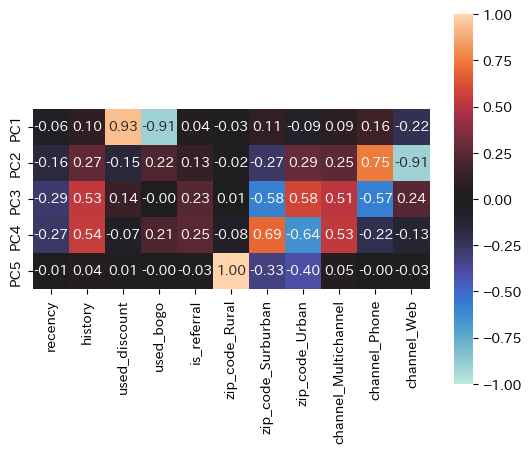

In [ ]:
# 可視化して確認
sns.heatmap(df_factor_loading.head(5), vmax=1.0, center=0.0, vmin=-1.0, square=True, annot=True, fmt='.2f');

In [ ]:
d_pca = copy.deepcopy(new_data)
d_pca.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35559 entries, 3 to 21306
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   history  21307 non-null  float64
 1   recency  21307 non-null  float64
 2   1        21307 non-null  float64
 3   2        21307 non-null  float64
 4   3        21307 non-null  float64
 5   4        21307 non-null  float64
 6   5        21307 non-null  float64
dtypes: float64(7)
memory usage: 2.2 MB


In [ ]:
d_pca

,history,recency,1,2,3,4,5
3,675.83,9.0,1.705203,0.268934,-1.999084,0.054866,-0.385633
8,675.07,9.0,1.187789,-2.057840,-0.441649,0.510223,-0.418275
13,101.64,2.0,-1.901456,-0.796752,0.879806,-1.344818,-0.595212
16,29.99,5.0,0.297638,1.686111,3.357895,1.499023,-0.352792
17,112.35,9.0,-1.448301,-1.168685,-0.013900,1.660852,-0.461538
...,...,...,...,...,...,...,...
21301,NaN,NaN,0.304390,2.140689,1.111297,-0.287394,-0.504391
21302,NaN,NaN,-1.925417,-0.862660,0.754229,-1.469985,-0.604324
21303,NaN,NaN,0.789320,-1.500939,0.820250,-2.041971,-0.587323
21304,NaN,NaN,-1.268188,1.859856,-0.088495,-1.185654,-0.606328


#ここは見なくて大丈夫

In [ ]:
#conversionでグループ化
not_buy = hot_df[hot_df['conversion']==0]
buy = hot_df[hot_df['conversion']==1]

####recency

<ipython-input-55-f69014dfc97b>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(buy['recency'], bins=12);
<ipython-input-55-f69014dfc97b>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(not_buy['recency'], bins=12);


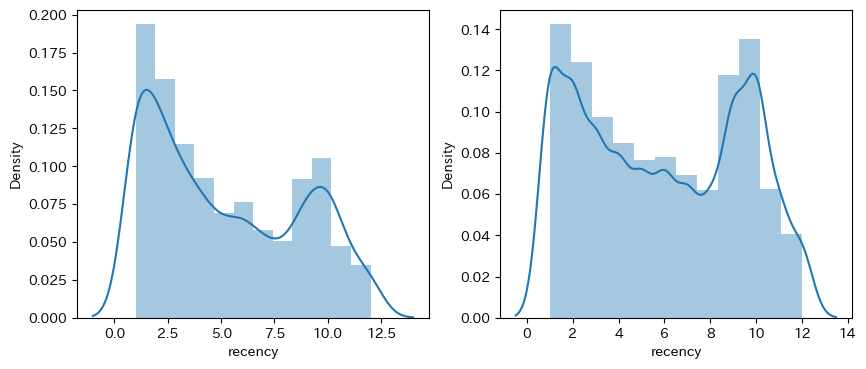

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
sns.distplot(buy['recency'], bins=12);
plt.subplot(1, 2, 2)
sns.distplot(not_buy['recency'], bins=12);

帰無仮説：正規分布である

In [ ]:
# コルモゴロフ・スミルノフ検定
stats.kstest(buy['recency'],"norm",args=(buy['recency'].mean(), buy['recency'].std()))

KstestResult(statistic=0.1609574544672055, pvalue=1.3232915081887845e-88, statistic_location=3, statistic_sign=1)

In [ ]:
# コルモゴロフ・スミルノフ検定
stats.kstest(not_buy['recency'],"norm",args=(not_buy['recency'].mean(), not_buy['recency'].std()))

KstestResult(statistic=0.13777621591108025, pvalue=8.68901329054542e-289, statistic_location=9, statistic_sign=-1)

↑どちらも正規分布ではない

帰無仮説（H_0）: 2 群間の平均値に差がない

In [ ]:
# Mann-Whitney(マンホイットニー)のU検定
stats.mannwhitneyu(buy["recency"], not_buy["recency"], alternative='two-sided')

MannwhitneyuResult(statistic=29839840.5, pvalue=5.727925519776182e-32)

↑2 群間の平均値に差がある



In [ ]:
group2 = hot_df.groupby('recency')
group2.mean()

,history,used_discount,used_bogo,is_referral,conversion,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,cluster
recency,,,,,,,,,,,,
1,366.294468,0.575768,0.571718,0.556531,0.233210,0.151873,0.437395,0.410732,0.172123,0.406007,0.421870,0.813027
2,311.038604,0.564294,0.563508,0.517499,0.221392,0.137633,0.453795,0.408573,0.162013,0.416044,0.421943,0.782934
3,274.455813,0.575140,0.546103,0.527764,0.208864,0.159450,0.432501,0.408049,0.142129,0.444727,0.413143,0.778910
4,250.967062,0.545994,0.563798,0.496142,0.194659,0.147774,0.436202,0.416024,0.115727,0.434421,0.449852,0.788724
5,234.133392,0.549046,0.559264,0.482970,0.168256,0.160082,0.427112,0.412807,0.128747,0.423025,0.448229,0.769074
6,215.649151,0.557895,0.533553,0.470395,0.178947,0.151316,0.459868,0.388816,0.118421,0.448026,0.433553,0.813158
7,208.032464,0.544622,0.540046,0.498856,0.157132,0.146453,0.447750,0.405797,0.097635,0.451564,0.450801,0.783371
8,200.601253,0.531117,0.561807,0.468883,0.154305,0.162830,0.449275,0.387894,0.104859,0.449275,0.445865,0.789429
9,186.604918,0.535390,0.539927,0.484120,0.148367,0.147005,0.456897,0.396098,0.100272,0.430127,0.469601,0.810345


####history

<ipython-input-60-829a159c8d72>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(buy['history'], bins=12);
<ipython-input-60-829a159c8d72>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(not_buy['history'], bins=12);


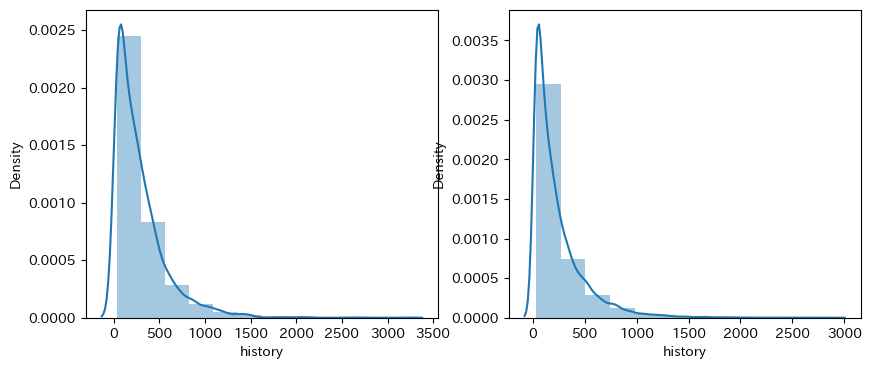

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
sns.distplot(buy['history'], bins=12);
plt.subplot(1, 2, 2)
sns.distplot(not_buy['history'], bins=12);

帰無仮説：正規分布である

In [ ]:
# コルモゴロフ・スミルノフ検定
stats.kstest(buy['history'],"norm",args=(buy['history'].mean(), buy['history'].std()))

KstestResult(statistic=0.1882428713513808, pvalue=2.7432304690833515e-121, statistic_location=29.99, statistic_sign=-1)

In [ ]:
# コルモゴロフ・スミルノフ検定
stats.kstest(not_buy['history'],"norm",args=(not_buy['history'].mean(), not_buy['history'].std()))

KstestResult(statistic=0.21064173727110064, pvalue=0.0, statistic_location=29.99, statistic_sign=-1)

↑どちらも正規分布ではない

帰無仮説（H_0）: 2 群間の平均値に差がない

In [ ]:
# Mann-Whitney(マンホイットニー)のU検定
stats.mannwhitneyu(buy["history"], not_buy["history"], alternative='two-sided')

MannwhitneyuResult(statistic=37846655.5, pvalue=5.54042169361182e-30)

↑2 群間の平均値に差がある



####数値変数

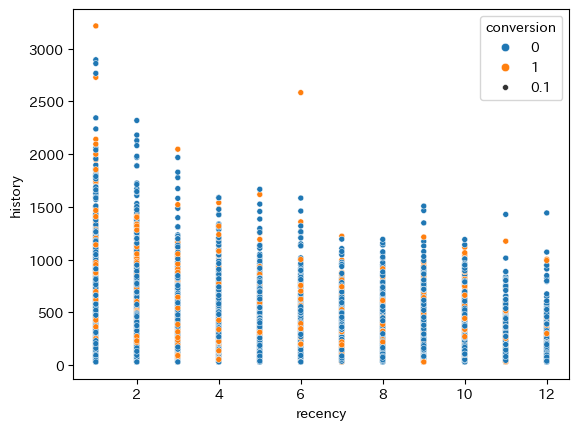

In [ ]:
sns.scatterplot(x='recency', y='history', hue='conversion', size=0.1, data=hot_df);

ここまで

##BuyOne

In [ ]:
df = BuyOne_df

####OneHotEncoding

In [ ]:
hot_df = pd.get_dummies(df, dtype=int)
hot_df.head()

,recency,history,used_discount,used_bogo,is_referral,conversion,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,0,0,1,0,0,1,0
2,7,180.65,0,1,1,0,0,1,0,0,0,1
4,2,45.34,1,0,0,0,0,0,1,0,0,1
5,6,134.83,0,1,0,1,0,1,0,0,1,0
6,9,280.20,1,0,1,0,0,1,0,0,1,0


In [ ]:
hot_df.shape

(21387, 12)

In [ ]:
group = hot_df.groupby('conversion')

In [ ]:
group.mean()

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
conversion,,,,,,,,,,,
0,5.863408,235.831049,0.558708,0.528624,0.516392,0.143259,0.453083,0.403659,0.117141,0.452256,0.430602
1,5.232242,280.121458,0.494132,0.670476,0.429586,0.179432,0.440704,0.379864,0.139901,0.384805,0.475293


In [ ]:
not_buy = hot_df[hot_df['conversion']==0]
buy = hot_df[hot_df['conversion']==1]

In [ ]:
buy.columns

Index(['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
       'conversion', 'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
       'channel_Multichannel', 'channel_Phone', 'channel_Web'],
      dtype='object')

In [ ]:
number = ['recency', 'history']
category = ['used_discount', 'used_bogo', 'is_referral',
       'conversion', 'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
       'channel_Multichannel', 'channel_Phone', 'channel_Web']

####χ二乗検定

帰無仮説：二つの変数は独立である

In [ ]:
for col in category:
    crosstab = pd.crosstab(hot_df['conversion'], hot_df[col])
    chi2, p, dof, ef = stats.chi2_contingency(crosstab, correction=False)
    if p < 0.05:
        print('列名：'+ col)
        print(f'χ 二乗値:{chi2}')
        print(f'p 値:{p}')
        print(ef)

列名：used_discount
χ 二乗値:46.277000197783096
p 値:1.0266202328707627e-11
[[8186.44050124 9962.55949876]
 [1460.55949876 1777.44050124]]
列名：used_bogo
χ 二乗値:223.4033088704067
p 値:1.6370442390004977e-50
[[8165.22551082 9983.77448918]
 [1456.77448918 1781.22551082]]
列名：is_referral
χ 二乗値:82.82410182094783
p 値:8.968968617611939e-20
[[9015.52232665 9133.47767335]
 [1608.47767335 1629.52232665]]
列名：conversion
χ 二乗値:21387.0
p 値:0.0
[[15401.23444148  2747.76555852]
 [ 2747.76555852   490.23444148]]
列名：zip_code_Rural
χ 二乗値:28.397117326781746
p 値:9.881233326638437e-08
[[15449.60461963  2699.39538037]
 [ 2756.39538037   481.60461963]]
列名：zip_code_Urban
χ 二乗値:6.481879302494555
p 値:0.01089796994864498
[[10888.38168046  7260.61831954]
 [ 1942.61831954  1295.38168046]]
列名：channel_Multichannel
χ 二乗値:13.422079047191847
p 値:0.0002486799341078541
[[15960.46158882  2188.53841118]
 [ 2847.53841118   390.46158882]]
列名：channel_Phone
χ 二乗値:50.68617385469906
p 値:1.0838036627708923e-12
[[10126.33922476  8022.66077524

In [ ]:
group.mean()

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
conversion,,,,,,,,,,,
0,5.863408,235.831049,0.558708,0.528624,0.516392,0.143259,0.453083,0.403659,0.117141,0.452256,0.430602
1,5.232242,280.121458,0.494132,0.670476,0.429586,0.179432,0.440704,0.379864,0.139901,0.384805,0.475293


In [ ]:
discussion = hot_df.query('used_bogo==1 and channel_Phone==0')
discussion.shape

(6646, 12)

In [ ]:
hot_df['conversion'].mean()

0.151400383410483

In [ ]:
discussion['conversion'].mean()

0.20117363827866386

####recency

<ipython-input-78-f69014dfc97b>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(buy['recency'], bins=12);
<ipython-input-78-f69014dfc97b>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(not_buy['recency'], bins=12);


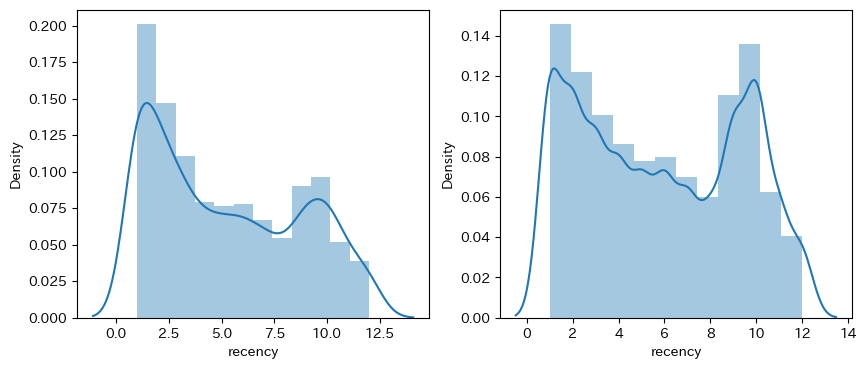

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
sns.distplot(buy['recency'], bins=12);
plt.subplot(1, 2, 2)
sns.distplot(not_buy['recency'], bins=12);

帰無仮説：正規分布である

In [ ]:
# コルモゴロフ・スミルノフ検定
stats.kstest(buy['recency'],"norm",args=(buy['recency'].mean(), buy['recency'].std()))

KstestResult(statistic=0.15780987719932937, pvalue=6.680849484171331e-71, statistic_location=3, statistic_sign=1)

In [ ]:
# コルモゴロフ・スミルノフ検定
stats.kstest(not_buy['recency'],"norm",args=(not_buy['recency'].mean(), not_buy['recency'].std()))

KstestResult(statistic=0.13480715289548417, pvalue=4.149298959232639e-288, statistic_location=9, statistic_sign=-1)

↑どちらも正規分布ではない

帰無仮説（H_0）: 2 群間の平均値に差がない

In [ ]:
# Mann-Whitney(マンホイットニー)のU検定
stats.mannwhitneyu(buy["recency"], not_buy["recency"], alternative='two-sided')

MannwhitneyuResult(statistic=26268507.5, pvalue=4.006245702665157e-22)

↑2 群間の平均値に差がある



In [ ]:
group2 = hot_df.groupby('recency')
group2.mean()

,history,used_discount,used_bogo,is_referral,conversion,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
recency,,,,,,,,,,,
1,364.361474,0.577203,0.574884,0.550696,0.197482,0.154076,0.442346,0.403579,0.188867,0.411531,0.399602
2,312.602127,0.574503,0.555420,0.551360,0.177426,0.146569,0.450670,0.402761,0.153877,0.420625,0.425497
3,276.290304,0.536658,0.573067,0.503741,0.163591,0.138653,0.472319,0.389027,0.137157,0.434414,0.428429
4,247.335637,0.532017,0.561939,0.505685,0.141233,0.152603,0.436266,0.411131,0.120886,0.439856,0.439258
5,232.544466,0.567869,0.534426,0.495738,0.149508,0.140984,0.476066,0.382951,0.131803,0.430164,0.438033
6,218.158215,0.543353,0.555556,0.486834,0.148362,0.146435,0.438664,0.414900,0.113680,0.432884,0.453436
7,207.718424,0.557437,0.527982,0.472754,0.146539,0.162739,0.450663,0.386598,0.085420,0.441090,0.473490
8,196.930587,0.568221,0.525907,0.485320,0.139033,0.164076,0.442142,0.393782,0.091537,0.433506,0.474957
9,186.634481,0.529133,0.544292,0.477499,0.126954,0.148271,0.453813,0.397916,0.089057,0.476078,0.434865


####history

<ipython-input-83-829a159c8d72>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(buy['history'], bins=12);
<ipython-input-83-829a159c8d72>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(not_buy['history'], bins=12);


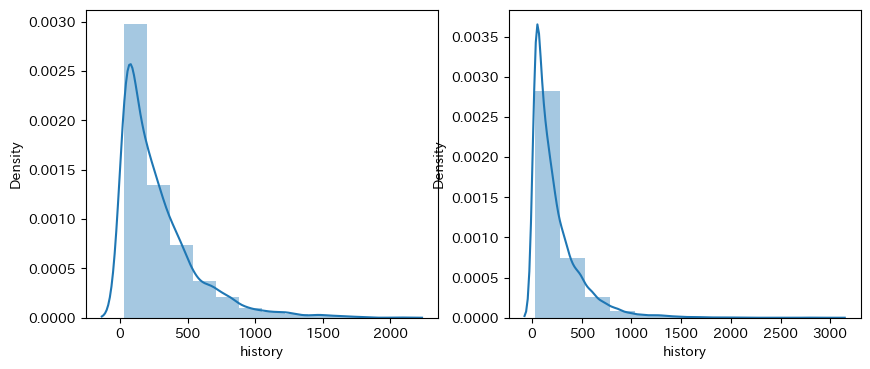

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
sns.distplot(buy['history'], bins=12);
plt.subplot(1, 2, 2)
sns.distplot(not_buy['history'], bins=12);

帰無仮説：正規分布である

In [ ]:
# コルモゴロフ・スミルノフ検定
stats.kstest(buy['history'],"norm",args=(buy['history'].mean(), buy['history'].std()))

KstestResult(statistic=0.18329990483834324, pvalue=1.0940379549269718e-95, statistic_location=29.99, statistic_sign=-1)

In [ ]:
# コルモゴロフ・スミルノフ検定
stats.kstest(not_buy['history'],"norm",args=(not_buy['history'].mean(), not_buy['history'].std()))

KstestResult(statistic=0.20578483537922226, pvalue=0.0, statistic_location=29.99, statistic_sign=-1)

↑どちらも正規分布ではない

帰無仮説（H_0）: 2 群間の平均値に差がない

In [ ]:
# Mann-Whitney(マンホイットニー)のU検定
stats.mannwhitneyu(buy["history"], not_buy["history"], alternative='two-sided')

MannwhitneyuResult(statistic=32382644.0, pvalue=1.7445225350899524e-20)

↑2 群間の平均値に差がある



##NoOffer

In [ ]:
df = NoOffer_df

####OneHotEncoding

In [ ]:
hot_df = pd.get_dummies(df, dtype=int)
hot_df.head()

,recency,history,used_discount,used_bogo,is_referral,conversion,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
1,6,329.08,1,1,1,0,1,0,0,0,0,1
14,4,241.42,0,1,1,0,1,0,0,1,0,0
15,3,58.13,1,0,1,1,0,0,1,0,0,1
20,9,29.99,0,1,1,0,0,1,0,0,1,0
23,2,29.99,0,1,1,0,0,0,1,0,1,0


In [ ]:
hot_df.shape

(21306, 12)

In [ ]:
group = hot_df.groupby('conversion')

In [ ]:
group.mean()

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
conversion,,,,,,,,,,,
0,5.849874,235.229693,0.548047,0.544423,0.517328,0.139519,0.455367,0.405114,0.119250,0.447070,0.433680
1,4.906278,288.475482,0.596817,0.574713,0.372679,0.213086,0.421309,0.365606,0.148099,0.359416,0.492485


In [ ]:
not_buy = hot_df[hot_df['conversion']==0]
buy = hot_df[hot_df['conversion']==1]

In [ ]:
buy.columns

Index(['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
       'conversion', 'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
       'channel_Multichannel', 'channel_Phone', 'channel_Web'],
      dtype='object')

In [ ]:
number = ['recency', 'history']
category = ['used_discount', 'used_bogo', 'is_referral',
       'conversion', 'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
       'channel_Multichannel', 'channel_Phone', 'channel_Web']

####χ二乗検定

帰無仮説：二つの変数は独立である

In [ ]:
for col in category:
    crosstab = pd.crosstab(hot_df['conversion'], hot_df[col])
    chi2, p, dof, ef = stats.chi2_contingency(crosstab, correction=False)
    if p < 0.05:
        print('列名：'+ col)
        print(f'χ 二乗値:{chi2}')
        print(f'p 値:{p}')
        print(ef)

列名：used_discount
χ 二乗値:19.456726838607874
p 値:1.0290477840800162e-05
[[ 8508.39369192 10535.60630808]
 [ 1010.60630808  1251.39369192]]
列名：used_bogo
χ 二乗値:7.487641658455704
p 値:0.006212386412013953
[[ 8614.75978598 10429.24021402]
 [ 1023.24021402  1238.75978598]]
列名：is_referral
χ 二乗値:169.2185419558799
p 値:1.0960918990772525e-38
[[9484.45902563 9559.54097437]
 [1126.54097437 1135.45902563]]
列名：conversion
χ 二乗値:21306.0
p 値:0.0
[[17022.15038017  2021.84961983]
 [ 2021.84961983   240.15038017]]
列名：zip_code_Rural
χ 二乗値:87.10465764653257
p 値:1.0292787261927433e-20
[[16238.25908195  2805.74091805]
 [ 1928.74091805   333.25908195]]
列名：zip_code_Surburban
χ 二乗値:9.469101386283167
p 値:0.002089617096717655
[[10440.86003943  8603.13996057]
 [ 1240.13996057  1021.86003943]]
列名：zip_code_Urban
χ 二乗値:13.139967718773418
p 値:0.00028906283814234907
[[11408.88087863  7635.11912137]
 [ 1355.11912137   906.88087863]]
列名：channel_Multichannel
χ 二乗値:15.674521354648348
p 値:7.523080244486324e-05
[[16714.6719234  

####recency

<ipython-input-96-f69014dfc97b>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(buy['recency'], bins=12);
<ipython-input-96-f69014dfc97b>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(not_buy['recency'], bins=12);


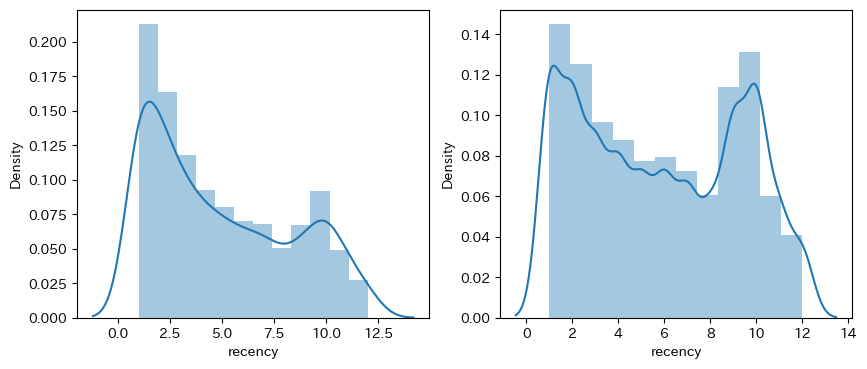

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
sns.distplot(buy['recency'], bins=12);
plt.subplot(1, 2, 2)
sns.distplot(not_buy['recency'], bins=12);

帰無仮説：正規分布である

In [ ]:
# コルモゴロフ・スミルノフ検定
stats.kstest(buy['recency'],"norm",args=(buy['recency'].mean(), buy['recency'].std()))

KstestResult(statistic=0.1650050903132682, pvalue=2.730029330679536e-54, statistic_location=3, statistic_sign=1)

In [ ]:
# コルモゴロフ・スミルノフ検定
stats.kstest(not_buy['recency'],"norm",args=(not_buy['recency'].mean(), not_buy['recency'].std()))

KstestResult(statistic=0.13361015123394482, pvalue=6.181262341749851e-297, statistic_location=9, statistic_sign=-1)

↑どちらも正規分布ではない

帰無仮説（H_0）: 2 群間の平均値に差がない

In [ ]:
# Mann-Whitney(マンホイットニー)のU検定
stats.mannwhitneyu(buy["recency"], not_buy["recency"], alternative='two-sided')

MannwhitneyuResult(statistic=18191977.5, pvalue=5.076298586450544e-34)

↑2 群間の平均値に差がある



In [ ]:
group2 = hot_df.groupby('recency')
group2.mean()

,history,used_discount,used_bogo,is_referral,conversion,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
recency,,,,,,,,,,,
1,348.824840,0.564456,0.588018,0.555369,0.148435,0.159879,0.434870,0.405251,0.191855,0.412992,0.395153
2,309.374666,0.585539,0.548795,0.529040,0.134334,0.146977,0.445674,0.407349,0.151324,0.425524,0.423153
3,272.574830,0.560950,0.563533,0.524793,0.126033,0.159607,0.445764,0.394628,0.135847,0.424070,0.440083
4,255.506729,0.556653,0.553748,0.523533,0.111563,0.151075,0.436374,0.412551,0.148170,0.417199,0.434631
5,232.816711,0.531312,0.570204,0.491101,0.110086,0.145023,0.448912,0.406065,0.108767,0.433751,0.457482
6,221.344359,0.574607,0.524869,0.479712,0.094895,0.149869,0.459424,0.390707,0.107984,0.445681,0.446335
7,206.960703,0.559262,0.527324,0.471966,0.100071,0.144074,0.471256,0.384670,0.112846,0.451384,0.435770
8,187.206804,0.555842,0.501718,0.496564,0.090206,0.135739,0.455326,0.408935,0.092784,0.439003,0.468213
9,184.362888,0.538570,0.525400,0.472248,0.065381,0.143932,0.456256,0.399812,0.088429,0.455786,0.455786


####history

<ipython-input-101-829a159c8d72>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(buy['history'], bins=12);
<ipython-input-101-829a159c8d72>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(not_buy['history'], bins=12);


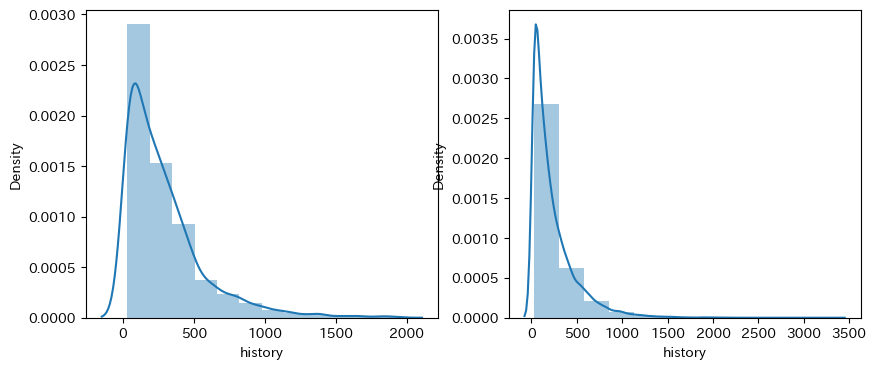

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
sns.distplot(buy['history'], bins=12);
plt.subplot(1, 2, 2)
sns.distplot(not_buy['history'], bins=12);

帰無仮説：正規分布である

In [ ]:
# コルモゴロフ・スミルノフ検定
stats.kstest(buy['history'],"norm",args=(buy['history'].mean(), buy['history'].std()))

KstestResult(statistic=0.179027841083988, pvalue=6.707112107501055e-64, statistic_location=29.99, statistic_sign=-1)

In [ ]:
# コルモゴロフ・スミルノフ検定
stats.kstest(not_buy['history'],"norm",args=(not_buy['history'].mean(), not_buy['history'].std()))

KstestResult(statistic=0.20446431576933505, pvalue=0.0, statistic_location=29.99, statistic_sign=-1)

↑どちらも正規分布ではない

帰無仮説（H_0）: 2 群間の平均値に差がない

In [ ]:
# Mann-Whitney(マンホイットニー)のU検定
stats.mannwhitneyu(buy["history"], not_buy["history"], alternative='two-sided')

MannwhitneyuResult(statistic=24372260.0, pvalue=1.1196806821392788e-24)

↑2 群間の平均値に差がある



##DF

In [ ]:
df = DF

###int型

In [ ]:
_df= df[['recency', 'history', 'conversion']]
_df

,recency,history,conversion
0,10,142.44,0
1,6,329.08,0
2,7,180.65,0
3,9,675.83,0
4,2,45.34,0
...,...,...,...
63995,10,105.54,0
63996,5,38.91,0
63997,6,29.99,0
63998,1,552.94,0


In [ ]:
group = _df.groupby('conversion')
group.mean()

,recency,history
conversion,,
0,5.872505,235.163403
1,5.131467,282.323739


In [ ]:
#conversionでグループ化
buy_df = df[df['conversion']==1]
notbuy_df = df[df['conversion']==0]

In [ ]:
buy_df.shape

(9394, 9)

In [ ]:
notbuy_df.shape

(54606, 9)

####recencyの検定

In [ ]:
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('bmh')

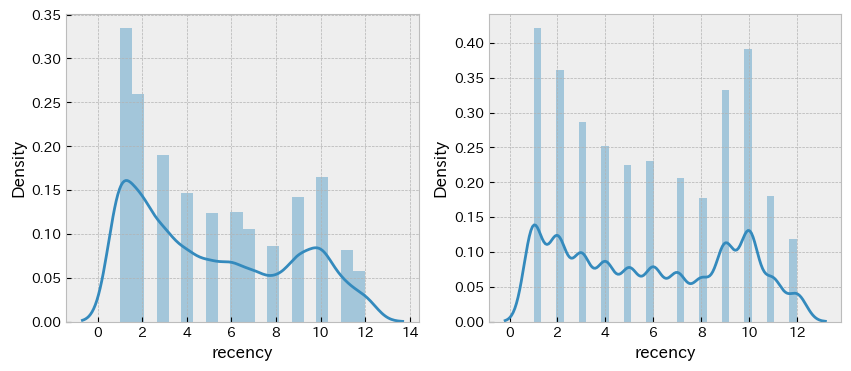

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
sns.distplot(buy_df['recency']);
plt.subplot(1, 2, 2)
sns.distplot(notbuy_df['recency']);

In [ ]:
#正規分布であるかどうか
stats.kstest(buy_df['recency'], 'norm', args=(buy_df['recency'].mean(), buy_df['recency'].std()))

KstestResult(statistic=0.1609238191797538, pvalue=5.285563780011284e-213, statistic_location=3, statistic_sign=1)

In [ ]:
#正規分布であるかどうか
stats.kstest(notbuy_df['recency'], 'norm', args=(notbuy_df['recency'].mean(), notbuy_df['recency'].std()))

KstestResult(statistic=0.1353400308271906, pvalue=0.0, statistic_location=9, statistic_sign=-1)

In [ ]:
# Mann-Whitney(マンホイットニー)のU検定
stats.mannwhitneyu(buy_df['recency'], notbuy_df['recency'], alternative='two-sided')

MannwhitneyuResult(statistic=224992552.5, pvalue=1.3651156524174674e-81)

↑差がある

####historyの検定

In [ ]:
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('bmh')

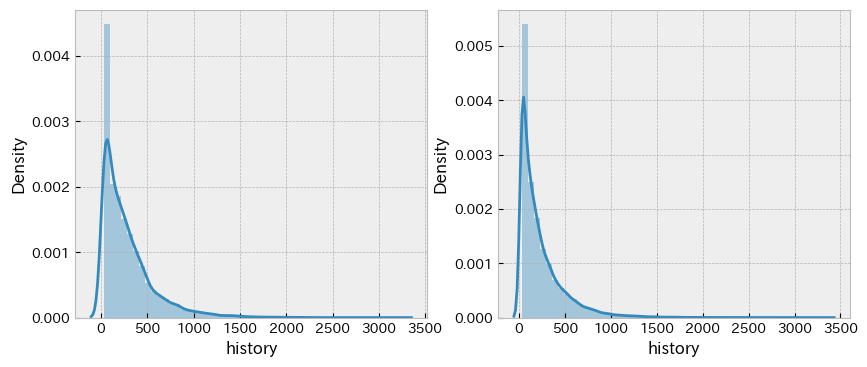

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
sns.distplot(buy_df['history']);
plt.subplot(1, 2, 2)
sns.distplot(notbuy_df['history']);

In [ ]:
#正規分布であるかどうか
distribution = 'norm'
static, pvalue = stats.kstest(buy_df['history'], distribution)
pvalue

0.0

In [ ]:
#正規分布であるかどうか
distribution = 'norm'
static, pvalue = stats.kstest(notbuy_df['history'], distribution)
pvalue

0.0

In [ ]:
# Mann-Whitney(マンホイットニー)のU検定
stats.mannwhitneyu(buy_df['history'], notbuy_df['history'], alternative='two-sided')

MannwhitneyuResult(statistic=285801528.0, pvalue=2.006166505322324e-70)

↑差がある

####recencyとhistoryの相関分析

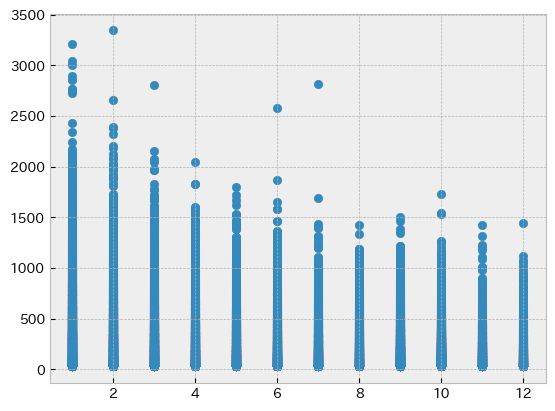

In [ ]:
plt.scatter(df['recency'], df['history']);

In [ ]:
df[['recency', 'history']].corr()

,recency,history
recency,1.000000,-0.246591
history,-0.246591,1.000000


↑ほぼ無相関

###recencyとconversion

In [ ]:
df['recency'].value_counts()

recency
1     8952
10    7565
2     7537
9     6441
3     5904
4     5077
6     4605
5     4510
7     4078
11    3504
8     3495
12    2332
Name: count, dtype: int64

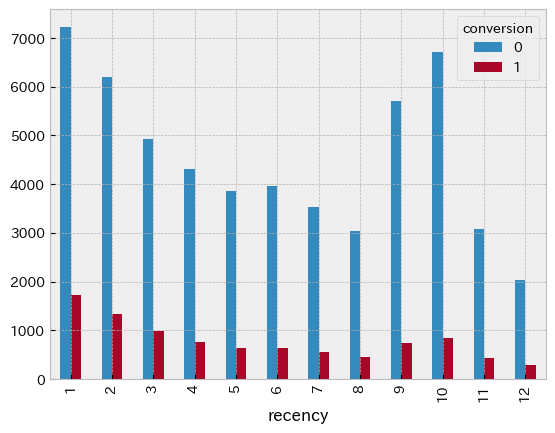

In [ ]:
crosstab = pd.crosstab(df['recency'], df['conversion'])
crosstab.plot.bar();

###str型

####used_discount

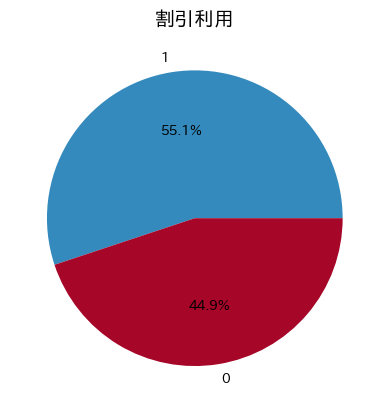

In [ ]:
x=df['used_discount'].value_counts()
plt.title('割引利用')
plt.pie(x, labels=x.index, autopct='%.1f%%');

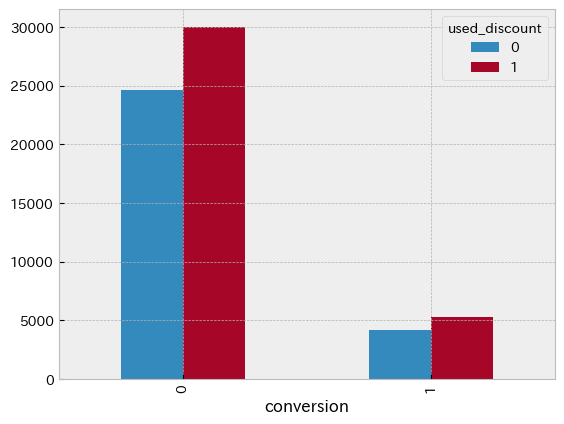

In [ ]:
crosstab = pd.crosstab(df['conversion'], df['used_discount'])
crosstab.plot.bar();

In [ ]:
group = df.groupby('used_discount')
group['conversion'].agg(['mean', 'median'])

,mean,median
used_discount,,
0,0.144150,0.0
1,0.148925,0.0


####used_bogo

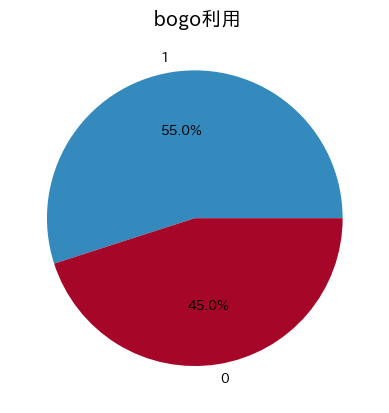

In [ ]:
x=df['used_bogo'].value_counts()
plt.title(' bogo利用')
plt.pie(x, labels=x.index, autopct='%.1f%%');

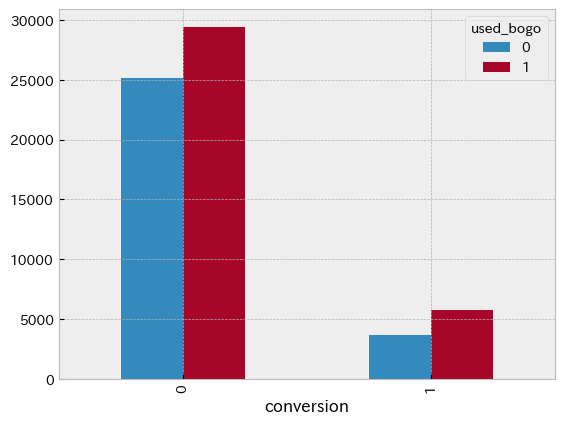

In [ ]:
crosstab = pd.crosstab(df['conversion'], df['used_bogo'])
crosstab.plot.bar();

In [ ]:
group = df.groupby('used_bogo')
group['conversion'].agg(['mean', 'median'])

,mean,median
used_bogo,,
0,0.126449,0.0
1,0.163436,0.0


####is_referral

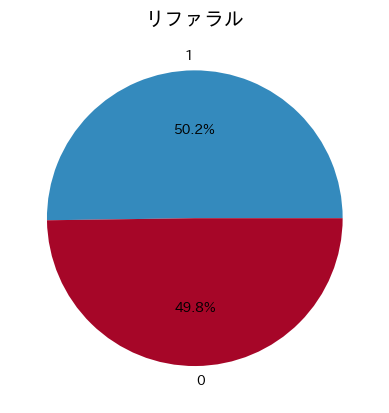

In [ ]:
x=df['is_referral'].value_counts()
plt.title('リファラル')
plt.pie(x, labels=x.index, autopct='%.1f%%');

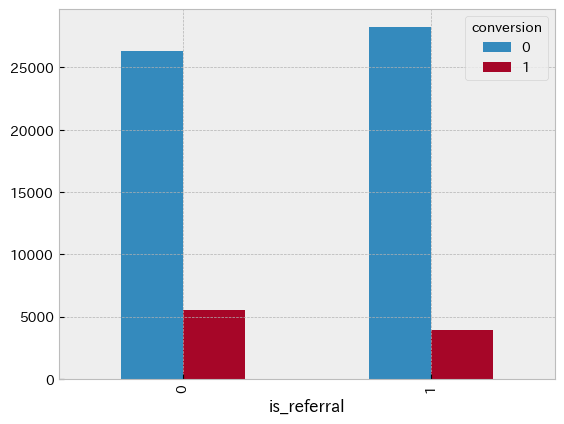

In [ ]:
crosstab = pd.crosstab(df['is_referral'], df['conversion'])
crosstab.plot.bar();

In [ ]:
group = df.groupby('is_referral')
group['conversion'].agg(['mean', 'median'])

,mean,median
is_referral,,
0,0.173060,0.0
1,0.120738,0.0


####zip_code

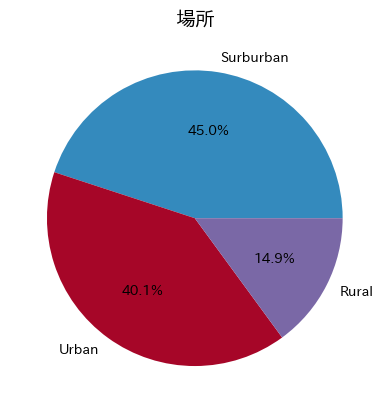

In [ ]:
x=df['zip_code'].value_counts()
plt.title('場所')
plt.pie(x, labels=x.index, autopct='%.1f%%');

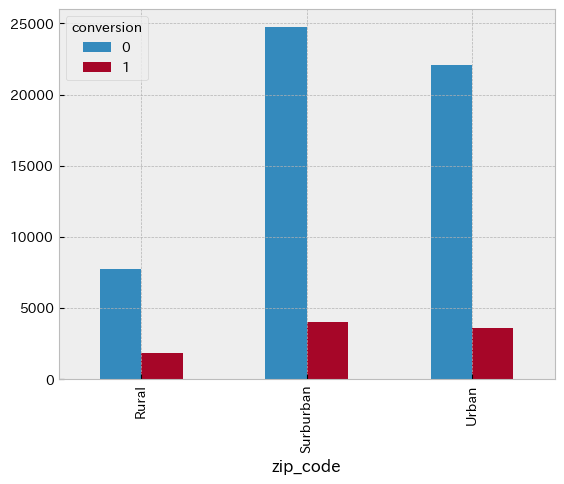

In [ ]:
crosstab = pd.crosstab(df['zip_code'], df['conversion'])
crosstab.plot.bar();

In [ ]:
group = df.groupby('zip_code')
group['conversion'].agg(['mean', 'median'])

,mean,median
zip_code,,
Rural,0.188121,0.0
Surburban,0.139943,0.0
Urban,0.139044,0.0


####channel

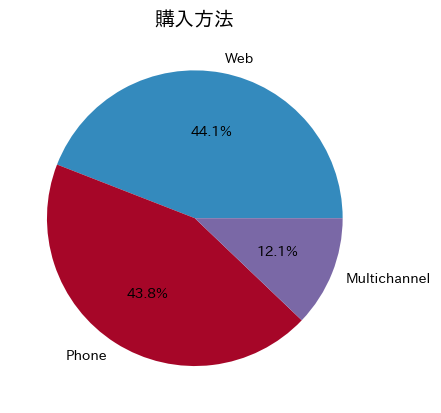

In [ ]:
x=df['channel'].value_counts()
plt.title('購入方法')
plt.pie(x, labels=x.index, autopct='%.1f%%');

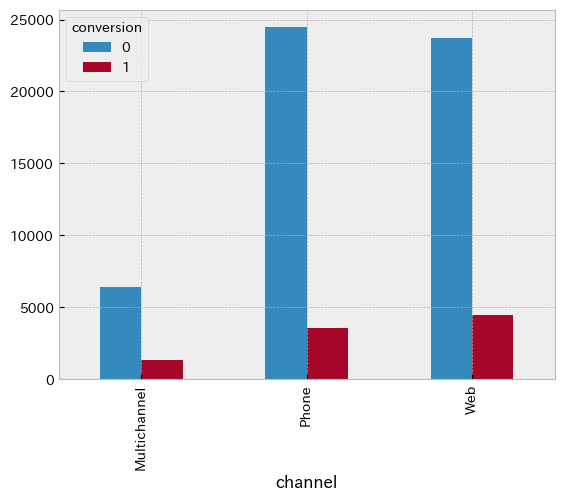

In [ ]:
crosstab = pd.crosstab(df['channel'], df['conversion'])
crosstab.plot.bar();

In [ ]:
group = df.groupby('channel')
group['conversion'].agg(['mean', 'median'])

,mean,median
channel,,
Multichannel,0.171734,0.0
Phone,0.127155,0.0
Web,0.159407,0.0


####offer

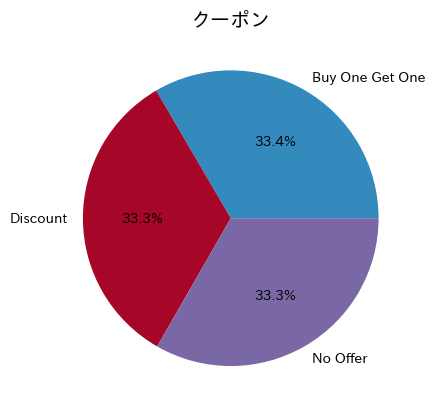

In [ ]:
x=df['offer'].value_counts()
plt.title('クーポン')
plt.pie(x, labels=x.index, autopct='%.1f%%');

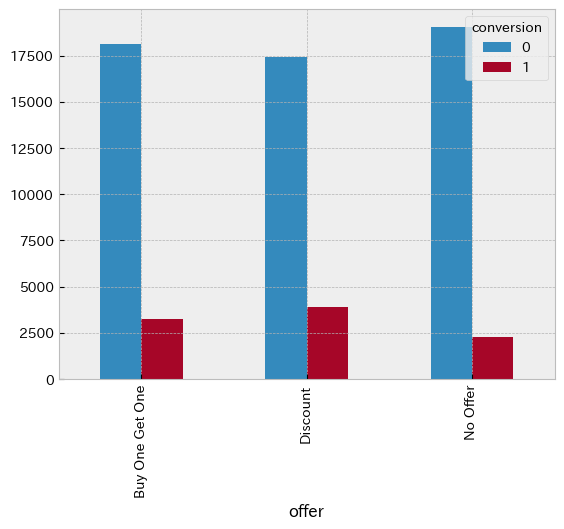

In [ ]:
crosstab = pd.crosstab(df['offer'], df['conversion'])
crosstab.plot.bar();

In [ ]:
group = df.groupby('offer')
group['conversion'].agg(['mean', 'median'])

,mean,median
offer,,
Buy One Get One,0.151400,0.0
Discount,0.182757,0.0
No Offer,0.106167,0.0


####conversion

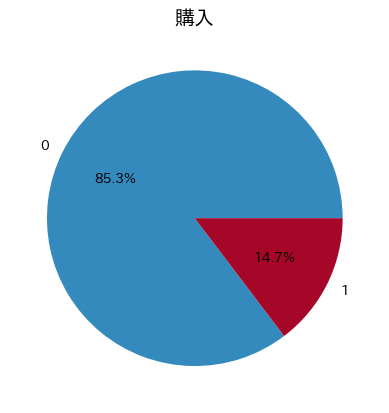

In [ ]:
x=df['conversion'].value_counts()
plt.title('購入')
plt.pie(x, labels=x.index, autopct='%.1f%%');

In [ ]:
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0


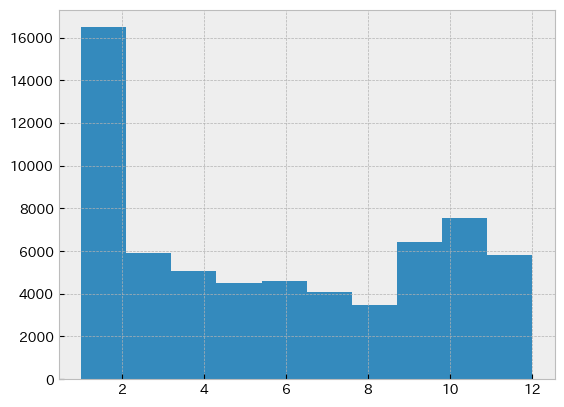

In [ ]:
df['recency'].hist();

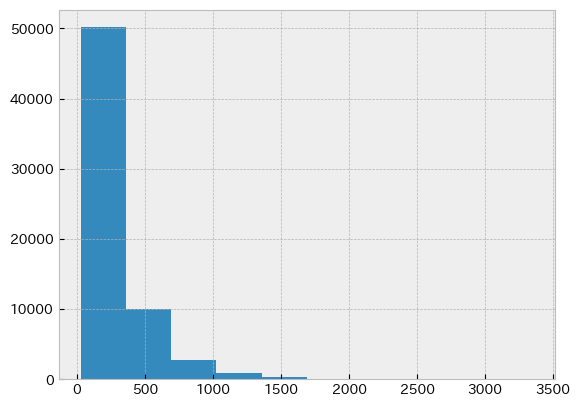

In [ ]:
df['history'].hist(bins=10);

###OneHotEncoding

In [ ]:
hot_df = pd.get_dummies(df, dtype=int)
hot_df.head()

,recency,history,used_discount,used_bogo,is_referral,conversion,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,offer_Buy One Get One,offer_Discount,offer_No Offer
0,10,142.44,1,0,0,0,0,1,0,0,1,0,1,0,0
1,6,329.08,1,1,1,0,1,0,0,0,0,1,0,0,1
2,7,180.65,0,1,1,0,0,1,0,0,0,1,1,0,0
3,9,675.83,1,0,1,0,1,0,0,0,0,1,0,1,0
4,2,45.34,1,0,0,0,0,0,1,0,0,1,1,0,0


<Axes: >

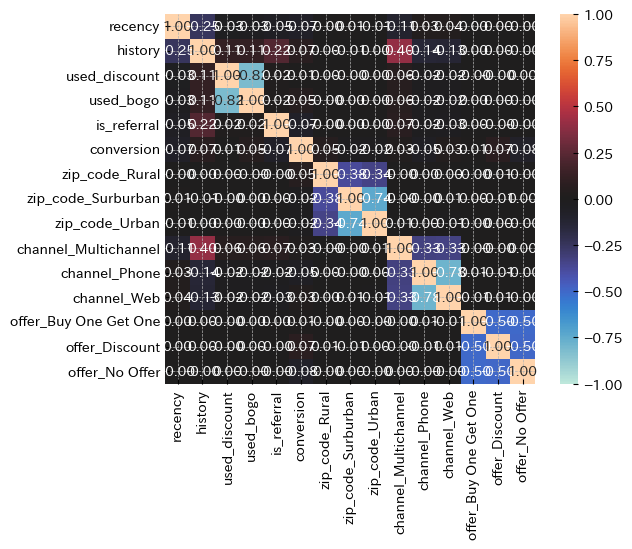

In [ ]:
sns.heatmap(hot_df.corr(), annot=True, square=True, vmax=1, vmin=-1, center=0, fmt='.2f')

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
x = hot_df.drop('conversion', axis=1)
y = hot_df['conversion']
x.head()

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,offer_Buy One Get One,offer_Discount,offer_No Offer
0,10,142.44,1,0,0,0,1,0,0,1,0,1,0,0
1,6,329.08,1,1,1,1,0,0,0,0,1,0,0,1
2,7,180.65,0,1,1,0,1,0,0,0,1,1,0,0
3,9,675.83,1,0,1,1,0,0,0,0,1,0,1,0
4,2,45.34,1,0,0,0,0,1,0,0,1,1,0,0


###重回帰

In [ ]:
x_scaled = scaler.fit_transform(x)
feature = pd.DataFrame(x_scaled, columns=hot_df.drop('conversion', axis=1).columns)
feature.head()

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,offer_Buy One Get One,offer_Discount,offer_No Offer
0,1.207751,-0.389003,0.902651,-1.104914,-1.00451,-0.419131,1.106380,-0.818119,-0.371511,1.133138,-0.888008,1.411550,-0.706452,-0.706427
1,0.067359,0.339614,0.902651,0.905048,0.99551,2.385888,-0.903849,-0.818119,-0.371511,-0.882505,1.126116,-0.708441,-0.706452,1.415574
2,0.352457,-0.239836,-1.107848,0.905048,0.99551,-0.419131,1.106380,-0.818119,-0.371511,-0.882505,1.126116,1.411550,-0.706452,-0.706427
3,0.922653,1.693278,0.902651,-1.104914,0.99551,2.385888,-0.903849,-0.818119,-0.371511,-0.882505,1.126116,-0.708441,1.415524,-0.706427
4,-1.073034,-0.768068,0.902651,-1.104914,-1.00451,-0.419131,-0.903849,1.222316,-0.371511,-0.882505,1.126116,1.411550,-0.706452,-0.706427


In [ ]:
import statsmodels.api as sm

In [ ]:
np.random.seed(0)
multi_ols = sm.OLS(y, sm.add_constant(feature))
result = multi_ols.fit()

In [ ]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             conversion   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     207.7
Date:                Tue, 09 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:42:32   Log-Likelihood:                -23208.
No. Observations:               64000   AIC:                         4.644e+04
Df Residuals:                   63988   BIC:                         4.655e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.1468      0.001    106.775      0.000       0.144       0.149
recency                  -0.0220      0.001    -15.540      0.000      -0.025      -0.019
history                   0.0145      0.002      8.706      0.000       0.011       0.018
used_discount             0.0442      0.003     17.268      0.000       0.039       0.049
used_bogo                 0.0530      0.003     20.703      0.000       0.048       0.058
is_referral              -0.0323      0.001    -22.860      0.000      -0.035      -0.029
zip_code_Rural            0.0135      0.001     12.332      0.000       0.011       0.016
zip_code_Surburban       -0.0044      0.001     -5.377      0.000      -0.006      -0.003
zip_code_Urban           -0.0053      0.001     -6.241      0.000      -0.007      -0.004
channel_Multichannel     -0.0018      0.001     -1.444      0.149      -0.004       0.001
channel_Phone            -0.0072      0.001     -8.582      0.000      -0.009      -0.006
channel_Web               0.0083      0.001     10.007      0.000       0.007       0.010
offer_Buy One Get One     0.0023      0.001      2.565      0.010       0.001       0.004
offer_Discount            0.0167      0.001     18.255      0.000       0.015       0.019
offer_No Offer           -0.0191      0.001    -20.820      0.000      -0.021      -0.017
==============================================================================
Omnibus:                    20397.703   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            47287.860
Skew:                           1.892   Prob(JB):                         0.00
Kurtosis:                       4.849   Cond. No.                     7.29e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.19e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
result.rsquared_adj

0.034301038563986586

In [ ]:
# 説明変数とt,p値, 標準偏回帰係数のデータフレームを作成
res_values = pd.DataFrame([result.tvalues[1:], result.pvalues[1:], result.params[1:]],
                          index=['t', 'p', 'coef']).T
res_values

,t,p,coef
recency,-15.539503,2.356951e-54,-0.022044
history,8.706340,3.211528e-18,0.014495
used_discount,17.267692,1.167268e-66,0.044176
used_bogo,20.703281,6.633969e-95,0.052972
is_referral,-22.860347,3.346009e-115,-0.032253
zip_code_Rural,12.332145,6.662593e-35,0.013450
zip_code_Surburban,-5.377037,7.598622e-08,-0.004444
zip_code_Urban,-6.241217,4.368902e-10,-0.005273
channel_Multichannel,-1.443760,1.488114e-01,-0.001787
channel_Phone,-8.581673,9.555896e-18,-0.007166


In [ ]:
# 条件抽出
# t値の絶対値が2以上かつp値が5%以下
res_values[(res_values['t'].abs()>=2.0)&(res_values['p']<0.05)].sort_values('t', ascending=False)

,t,p,coef
used_bogo,20.703281,6.633969e-95,0.052972
offer_Discount,18.255100,2.911645e-74,0.016736
used_discount,17.267692,1.167268e-66,0.044176
zip_code_Rural,12.332145,6.662593e-35,0.013450
channel_Web,10.006692,1.482363e-23,0.008335
history,8.706340,3.211528e-18,0.014495
offer_Buy One Get One,2.564669,1.032970e-02,0.002349
zip_code_Surburban,-5.377037,7.598622e-08,-0.004444
zip_code_Urban,-6.241217,4.368902e-10,-0.005273
channel_Phone,-8.581673,9.555896e-18,-0.007166


###主成分分析

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(random_state=0)
#主成分分析の実行
feature = pca.fit_transform(x_scaled)

In [ ]:
# 寄与率
variance_ratio = pca.explained_variance_ratio_

pd.DataFrame(
    variance_ratio,
    index=[f'PC{x+1}' for x in range(len(variance_ratio))],
    columns=['寄与率']
)

,寄与率
PC1,1.298137e-01
PC2,1.276953e-01
PC3,1.250975e-01
PC4,1.234182e-01
PC5,1.071854e-01
PC6,1.070674e-01
PC7,8.995019e-02
PC8,7.044394e-02
PC9,6.717104e-02
PC10,4.128019e-02


In [ ]:
# 主成分負荷量
factor_loading = pca.components_ * np.c_[np.sqrt(pca.explained_variance_)]

df_factor_loading = pd.DataFrame(
    factor_loading,
    index=[f'PC{x+1}' for x in range(len(factor_loading))],
    columns=x.columns
)
df_factor_loading.head(3)

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,offer_Buy One Get One,offer_Discount,offer_No Offer
PC1,-0.025418,0.036021,0.955361,-0.945326,0.015612,0.007054,-0.055448,0.051150,0.040775,0.004406,-0.031214,-0.010757,-0.007007,0.017774
PC2,-0.053272,0.086803,-0.024969,0.047162,0.053954,0.011129,-0.252385,0.248082,0.085864,0.876329,-0.932125,0.031960,-0.032577,0.000587
PC3,-0.337443,0.609529,0.020842,0.143276,0.269856,0.031521,-0.571122,0.556774,0.586648,-0.432958,0.046900,-0.019573,0.027957,-0.008366


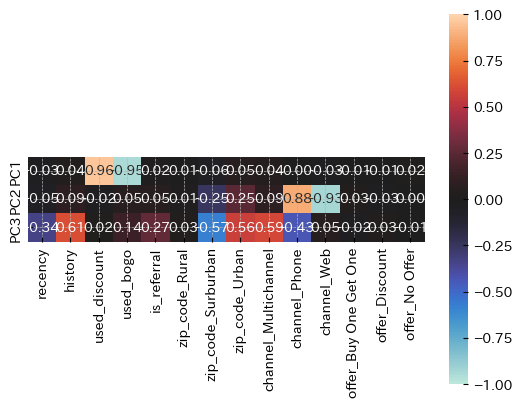

In [ ]:
# 可視化して確認
sns.heatmap(df_factor_loading.head(3), vmax=1.0, center=0.0, vmin=-1.0, square=True, annot=True, fmt='.2f');

In [ ]:
# 主成分得点でプロットする
def feature_plot(x=1, y=2):
    plt.figure(figsize=(6, 6))
    plt.title(f'第{x}, 第{y}主成分得点のプロット')
    plt.scatter(feature[:, x-1], feature[:, y-1], alpha=0.8, c=list(df.iloc[:, -1]))
    plt.xlabel(f'PC{x}')
    plt.ylabel(f'PC{y}')
    plt.colorbar()
    plt.show()

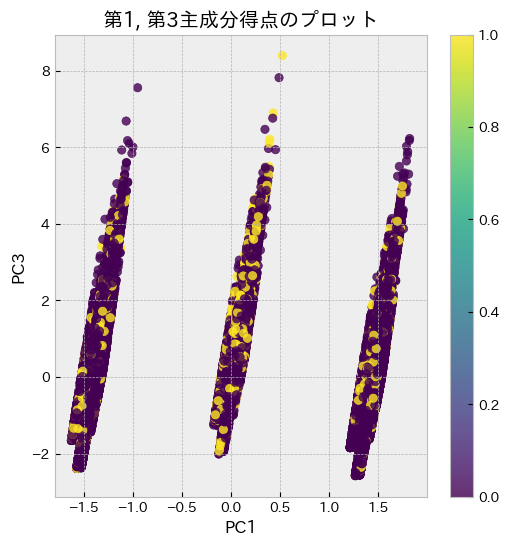

In [ ]:
feature_plot(1,3)

####クラスタリング

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
sse = []

for i  in range(1,15):                # 1~10クラスタまで一気に計算
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(x_scaled)             # クラスタリングの計算を実行
    sse.append(kmeans.inertia_)   # kmeans.fitするとkmeans.inertia_が得られる

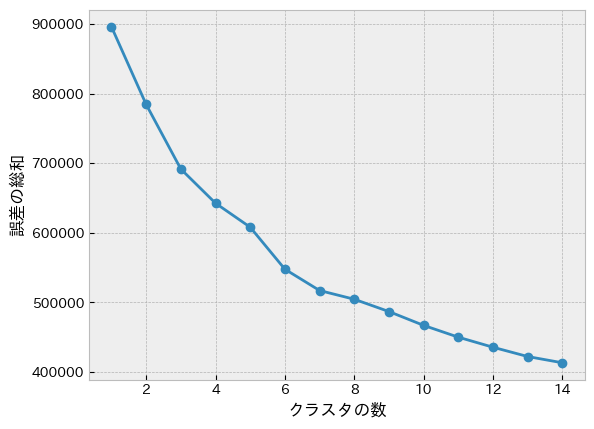

In [ ]:
plt.plot(range(1,15), sse , marker='o')
plt.xlabel('クラスタの数')
plt.ylabel('誤差の総和')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=0)

kmeans.fit(x_scaled)

cluster = kmeans.labels_
print(cluster)

[0 4 3 ... 1 5 3]


In [ ]:
# cluster、満足度のカラム追加
hot_df['cluster'] = cluster
hot_df.head(2)

,recency,history,used_discount,used_bogo,is_referral,conversion,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,offer_Buy One Get One,offer_Discount,offer_No Offer,cluster
0,10,142.44,1,0,0,0,0,1,0,0,1,0,1,0,0,0
1,6,329.08,1,1,1,0,1,0,0,0,0,1,0,0,1,4


In [ ]:
# クラスターごとにグループ分け
groups = hot_df.groupby('cluster')
groups.size()

cluster
0    12509
1    11289
2    12026
3    11899
4     8431
5     7846
dtype: int64

In [ ]:
# 代表値を取得
groups.agg(['min', 'max', 'mean', 'median'])

recency                      history                                \
            min max      mean median     min      max        mean   median   
cluster                                                                      
0             1  12  5.951235    6.0   29.99  1707.68  198.752154  129.590   
1             1  12  5.874922    6.0   29.99  1765.52  200.869071  132.450   
2             1  12  5.911276    6.0   29.99  1794.13  201.236663  131.310   
3             1  12  5.921338    6.0   29.99  1833.93  200.816920  129.260   
4             1  12  5.859329    6.0   29.99  2039.13  204.767799  135.770   
5             1  12  4.736936    4.0  200.02  3345.93  535.774966  453.075   

        used_discount      ... offer_Buy One Get One        offer_Discount  \
                  min max  ...                  mean median            min   
cluster                    ...                                               
0                   0   1  ...              0.339436    0.0              0   
1                   0   1  ...              0.337054    0.0              0   
2                   1   1  ...              0.333028    0.0              0   
3                   0   1  ...              0.329103    0.0              0   
4                   0   1  ...              0.332582    0.0              0   
5                   0   1  ...              0.332781    0.0              0   

                             offer_No Offer                       
        max      mean median            min max      mean median  
cluster                                                           
0         1  0.328483    0.0              0   1  0.332081    0.0  
1         1  0.329790    0.0              0   1  0.333156    0.0  
2         1  0.331116    0.0              0   1  0.335856    0.0  
3         1  0.336919    0.0              0   1  0.333978    0.0  
4         1  0.341359    0.0              0   1  0.326059    0.0  
5         1  0.332144    0.0              0   1  0.335075    0.0  

[6 rows x 60 columns]